# Example 3: Wave propagation calculators

Use RVT input motion with:
1. Linear elastic
2. Equivalent linear (e.g., SHAKE)
3. Frequency-dependent equivalent linear

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline
# Larger figures
mpl.rcParams['figure.dpi'] = 150

## Create a point source theory RVT motion

In [2]:
motion = pysra.motion.SourceTheoryRvtMotion(7.0, 30, 'wna')
motion.calc_fourier_amps()

## Create site profile

Create a simple soil profile with a single soil layer with nonlinear properties defined by the Darendeli nonlinear model.

In [3]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200),
        30, 400
    ),
    pysra.site.Layer(
        pysra.site.SoilType(
            'Rock', 24., None, 0.01
        ),
        0, 1200
    ),
])

## Create the site response calculator

In [4]:
calcs = [
    ('LE', pysra.propagation.LinearElasticCalculator()),
    ('EQL', pysra.propagation.EquivalentLinearCalculator(
        strain_ratio=0.65)),
    ('FDM', pysra.propagation.FrequencyDependentEqlCalculator(
        use_smooth_spectrum=False)),
]

## Specify the output

In [5]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs, 
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0), 
        # Damping
        0.05
    ),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs, 
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1), 
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0), 
        # Damping
        0.05
    ),
    
)

## Perform the calculation

Compute the response of the site, and store the state within the calculation object. Use the calculator, to compute the outputs.

In [6]:
for name, calc in calcs:
    calc(motion, profile, profile.location('outcrop', index=-1))
    outputs(calc, name)

/home/albert/Documents/programs/pysra/pysra/site.py:95: RuntimeWarning: divide by zero encountered in log
  values = self._interpolater(np.log(strains))


## Plot the outputs

Create a few plots of the output.

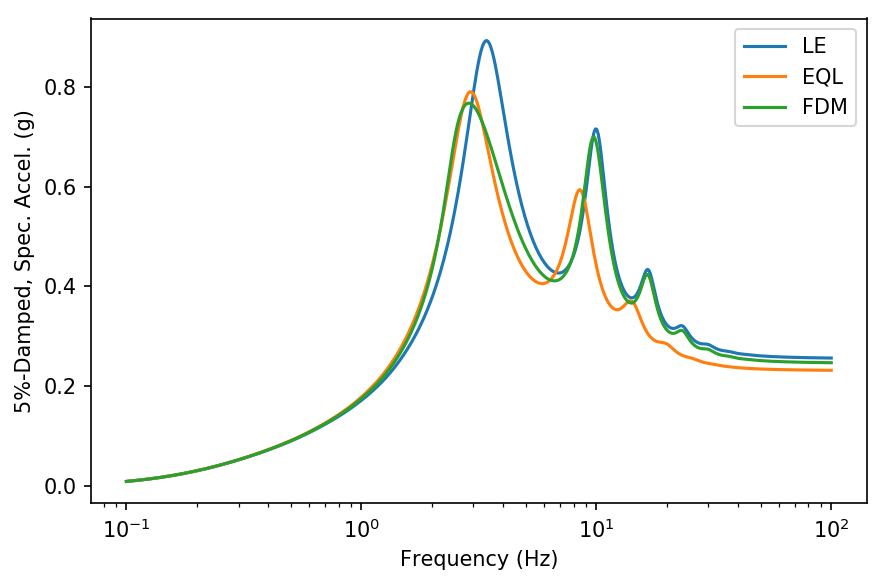

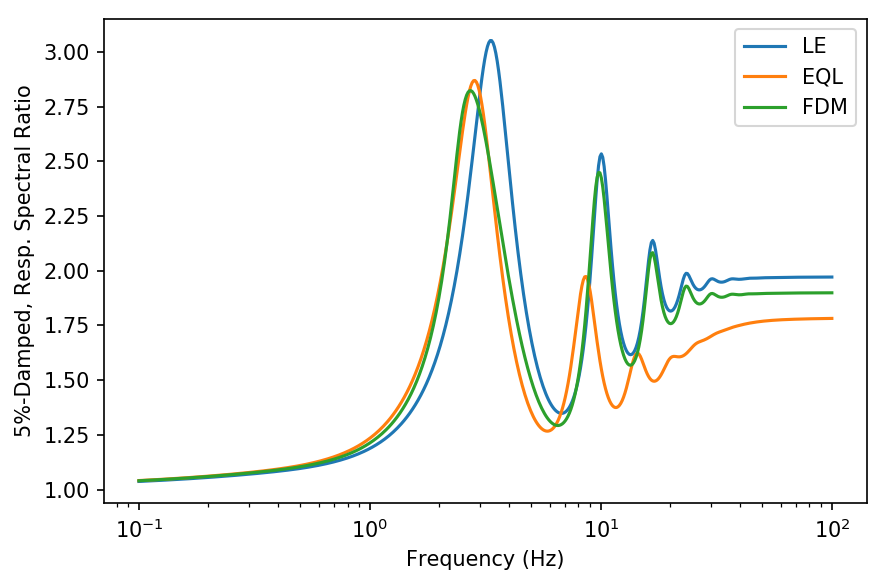

In [7]:
for o in outputs:
    fig, ax = plt.subplots()
    for name, refs, values in o.iter_results():
        ax.plot(refs, values, label=name)
    ax.set(xlabel=o.xlabel, xscale='log', ylabel=o.ylabel)
    ax.legend()
    fig.tight_layout();